In [1]:
from google.colab import files
uploaded = files.upload()

Saving Divvy Time Series Dataset - Sheet1.csv to Divvy Time Series Dataset - Sheet1 (1).csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.vector_ar.var_model import VARResults

In [3]:
df = pd.read_csv('Divvy Time Series Dataset - Sheet1.csv')
df.head(5)

,Year,Month,Total Counts,Classic Bike Count,Electric Bike Count,Docked Bike Count,Electric Scooter Count,Casual User Count,Member User Count
0,2020.0,4,84776,NaN,NaN,84776.0,NaN,23628,61148
1,NaN,5,200274,NaN,NaN,200274.0,NaN,86909,113365
2,NaN,6,343005,NaN,NaN,343005.0,NaN,154718,188287
3,NaN,7,551480,NaN,1935.0,549545.0,NaN,269296,282184
4,NaN,8,622361,NaN,66195.0,556166.0,NaN,289661,332700


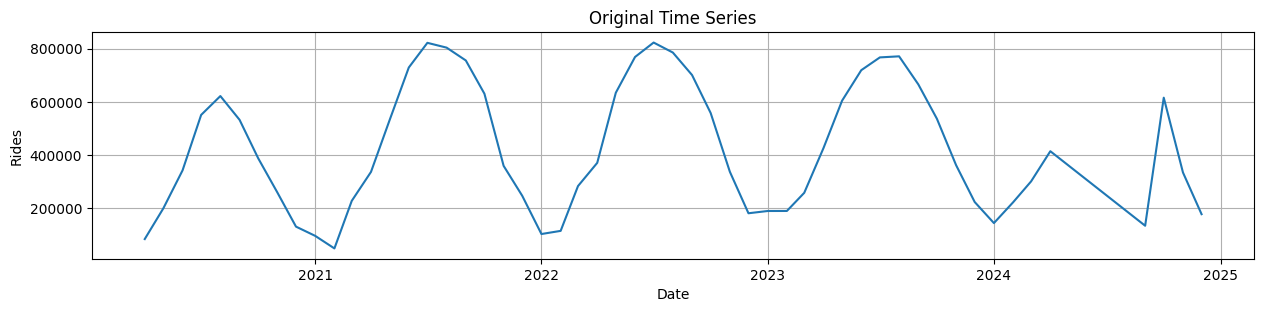

In [4]:
# Prepare data
df['Year'] = df['Year'].ffill()
df['date'] = pd.to_datetime(df.apply(lambda x: f"{int(x['Year'])}-{int(x['Month'])}-01", axis=1))

# Create time series
ts_df = pd.DataFrame({
    'date': df['date'],
    'rides': df['Total Counts']
}).set_index('date')

# Remove summer 2024 months
ts_df = ts_df[~((ts_df.index.year == 2024) & (ts_df.index.month.isin([5, 6, 7, 8])))]

def run_stationarity_tests(series, title):
    """Run ADF and KPSS tests and print results"""
    print(f"\n=== Stationarity Tests for {title} ===")

    # ADF Test
    adf_result = adfuller(series.dropna())
    print("\nAugmented Dickey-Fuller Test:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.4f}")

    # KPSS Test
    kpss_result = kpss(series.dropna(), regression='c', nlags="auto")
    print("\nKPSS Test:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.4f}")

# Original Series Analysis
plt.figure(figsize=(15, 10))

# Plot original series
plt.subplot(311)
plt.plot(ts_df.index, ts_df['rides'])
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Rides')
plt.grid(True)

In [5]:
# Run stationarity tests
run_stationarity_tests(ts_df['rides'], "Original Series")


=== Stationarity Tests for Original Series ===

Augmented Dickey-Fuller Test:
ADF Statistic: -5.8595
p-value: 0.0000
Critical values:
	1%: -3.5715
	5%: -2.9226
	10%: -2.5993

KPSS Test:
KPSS Statistic: 0.0690
p-value: 0.1000
Critical values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390


<ipython-input-4-1d337bf70ce6>:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags="auto")


=== Original Series ===

Significant ACF lags:
Lag 1: 0.766
Lag 2: 0.448
Lag 4: -0.363
Lag 5: -0.620
Lag 6: -0.689
Lag 7: -0.562
Lag 8: -0.290
Lag 10: 0.359
Lag 11: 0.550
Lag 12: 0.589
Lag 13: 0.463
Lag 16: -0.334
Lag 17: -0.480
Lag 18: -0.501
Lag 19: -0.380
Lag 23: 0.318
Lag 24: 0.314

Significant PACF lags:
Lag 1: 0.781
Lag 2: -0.370
Lag 3: -0.470
Lag 4: -0.508
Lag 22: -0.272

=== Seasonal Difference (lag=3) ===

Significant ACF lags:
Lag 1: 0.790
Lag 2: 0.440
Lag 4: -0.486
Lag 5: -0.775
Lag 6: -0.840
Lag 7: -0.681
Lag 8: -0.338
Lag 10: 0.453
Lag 11: 0.688
Lag 12: 0.732
Lag 13: 0.572
Lag 16: -0.406
Lag 17: -0.584
Lag 18: -0.595
Lag 19: -0.434
Lag 22: 0.337
Lag 23: 0.456
Lag 24: 0.432

Significant PACF lags:
Lag 1: 0.806
Lag 2: -0.545
Lag 3: -0.785
Lag 4: -0.460
Lag 5: -0.312
Lag 6: -0.522
Lag 7: -0.863
Lag 8: -3.998
Lag 9: 1.311
Lag 10: 0.625
Lag 11: 0.549
Lag 12: 0.697
Lag 13: 1.503
Lag 14: -2.582
Lag 15: -0.727
Lag 16: -0.508
Lag 17: -0.356
Lag 21: -0.473
Lag 22: -0.782
Lag 23: -2.

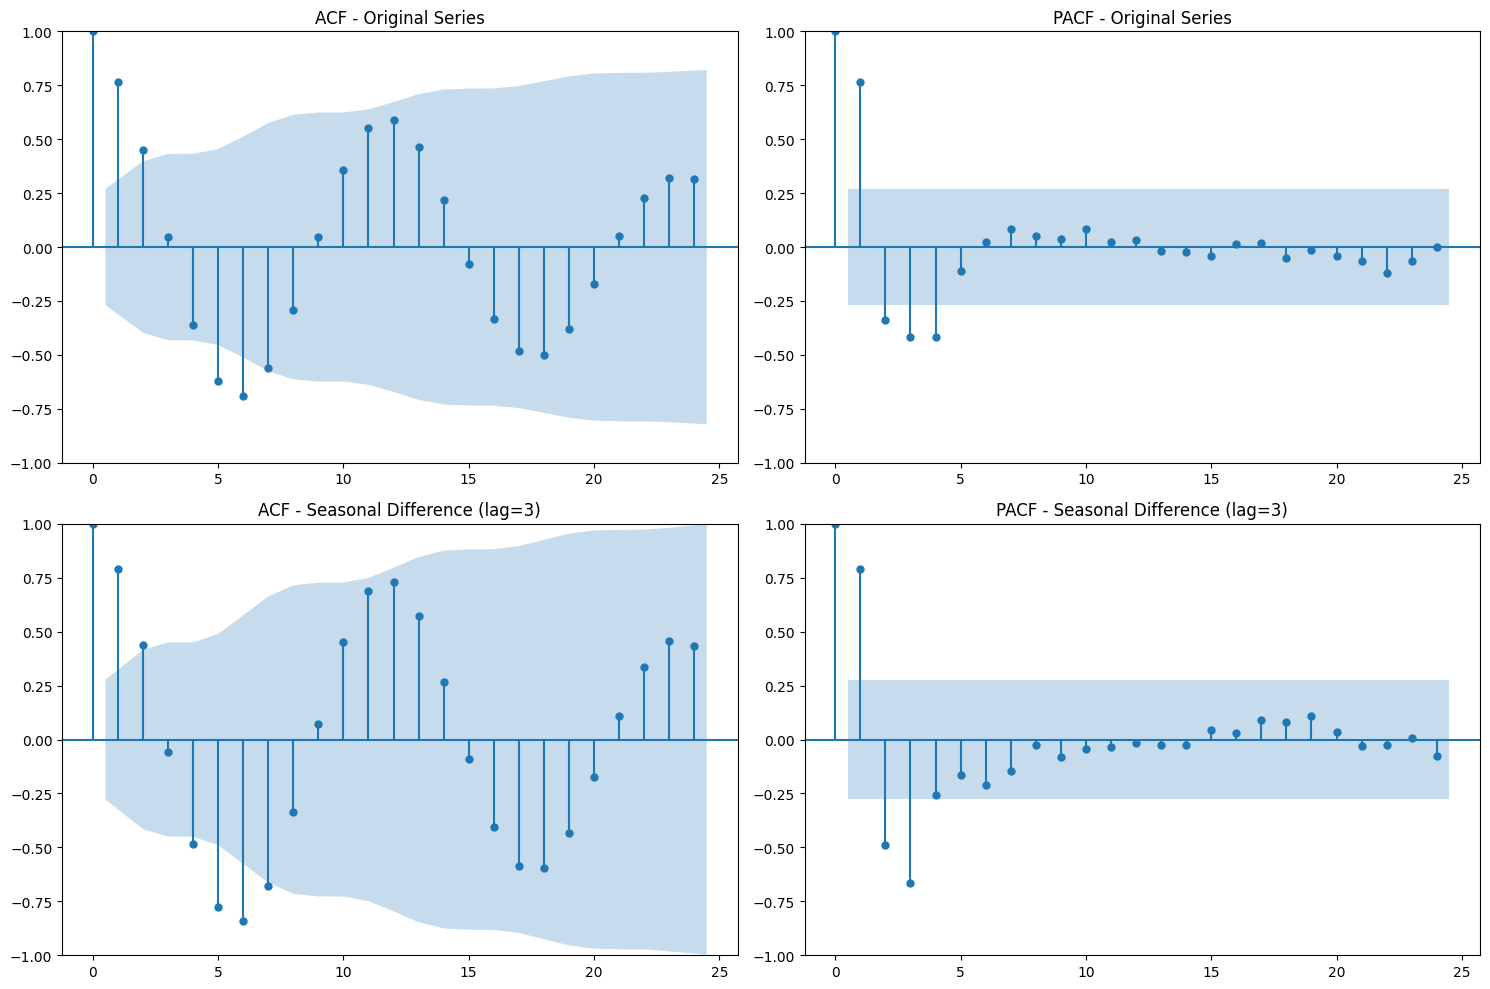

In [8]:
# Create figure for ACF and PACF plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Regular ACF and PACF
plot_acf(ts_df['rides'], lags=24, ax=ax1, title='ACF - Original Series')
plot_pacf(ts_df['rides'], lags=24, ax=ax2, title='PACF - Original Series')

# Calculate and plot seasonal ACF/PACF (lag 3 for quarterly seasonality)
seasonal_data = ts_df['rides'].diff(3).dropna()
plot_acf(seasonal_data, lags=24, ax=ax3, title='ACF - Seasonal Difference (lag=3)')
plot_pacf(seasonal_data, lags=24, ax=ax4, title='PACF - Seasonal Difference (lag=3)')

plt.tight_layout()

# Print significant lags
def print_significant_lags(series, alpha=0.05):
    acf_vals = acf(series, nlags=24)
    pacf_vals = pacf(series, nlags=24)

    # Calculate confidence intervals
    conf_int = 1.96/np.sqrt(len(series))

    print("\nSignificant ACF lags:")
    for i, val in enumerate(acf_vals):
        if abs(val) > conf_int and i > 0:  # Skip lag 0
            print(f"Lag {i}: {val:.3f}")

    print("\nSignificant PACF lags:")
    for i, val in enumerate(pacf_vals):
        if abs(val) > conf_int and i > 0:  # Skip lag 0
            print(f"Lag {i}: {val:.3f}")

print("=== Original Series ===")
print_significant_lags(ts_df['rides'])

print("\n=== Seasonal Difference (lag=3) ===")
print_significant_lags(seasonal_data)

In [9]:
# Fit SARIMA model based on ACF/PACF analysis
model = SARIMAX(ts_df['rides'],
                order=(2, 0, 1),           # (p,d,q) from ACF/PACF analysis
                seasonal_order=(1, 0, 1, 3),  # (P,D,Q,s) quarterly seasonality
                enforce_stationarity=True)

results = model.fit()

# Get predictions and confidence intervals
predictions = results.get_prediction(start=ts_df.index[0])
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

# Calculate metrics
actual = ts_df['rides']
predicted = predicted_mean
residuals = actual - predicted

# Print model summary
print("=" * 50)
print("SARIMA(2,0,1)(1,0,1,3) MODEL SUMMARY")
print("=" * 50)

print("\nModel Parameters:")
print(results.summary().tables[1].as_text())

print("\nModel Information Criteria:")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")
print(f"HQIC: {results.hqic:.2f}")

print("\nPerformance Metrics:")
print(f"R-squared (R²): {r2_score(actual, predicted):.3f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(actual, predicted):,.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(actual, predicted)):,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs((actual - predicted) / actual)) * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,1)(1,0,1,3) MODEL SUMMARY

Model Parameters:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0596      0.336     -0.177      0.859      -0.718       0.599
ar.L2          0.8935      0.269      3.328      0.001       0.367       1.420
ma.L1          0.7944      0.273      2.907      0.004       0.259       1.330
ar.S.L3       -0.2492      0.269     -0.928      0.353      -0.776       0.277
ma.S.L3        0.9660      0.503      1.920      0.055      -0.020       1.952
sigma2      1.865e+10   4.69e-11   3.98e+20      0.000    1.87e+10    1.87e+10

Model Information Criteria:
AIC: 1416.86
BIC: 1428.68
HQIC: 1421.41

Performance Metrics:
R-squared (R²): 0.679
Mean Absolute Error (MAE): 114,691.02
Root Mean Squared Error (RMSE): 135,078.59
Mean Absolute Percentage Error (MAPE): 39.77%


In [10]:
# Add seasonal indicators
ts_df['month'] = ts_df.index.month
ts_df['season'] = pd.cut(ts_df['month'],
                        bins=[0, 3, 6, 9, 12],
                        labels=['Winter', 'Spring', 'Summer', 'Fall'])

# Create seasonal dummies
seasonal_dummies = pd.get_dummies(ts_df['season'], prefix='season')
ts_df = pd.concat([ts_df, seasonal_dummies], axis=1)

# Fit improved SARIMA model
# Simplified model with external regressors for seasonality
model = SARIMAX(ts_df['rides'],
                order=(1, 0, 1),           # Simplified ARIMA order
                seasonal_order=(1, 0, 1, 3),  # Keep quarterly seasonality
                exog=seasonal_dummies,     # Add seasonal dummies
                enforce_stationarity=True)

results = model.fit()

# Get predictions
predictions = results.get_prediction(start=ts_df.index[0], exog=seasonal_dummies)
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

# Calculate metrics
actual = ts_df['rides']
predicted = predicted_mean
residuals = actual - predicted

# Print model summary
print("=" * 50)
print("IMPROVED SARIMA MODEL SUMMARY")
print("=" * 50)

print("\nModel Parameters:")
print(results.summary().tables[1].as_text())

print("\nModel Information Criteria:")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")
print(f"HQIC: {results.hqic:.2f}")

print("\nPerformance Metrics:")
print(f"R-squared (R²): {r2_score(actual, predicted):.3f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(actual, predicted):,.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(actual, predicted)):,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs((actual - predicted) / actual)) * 100:.2f}%")


IMPROVED SARIMA MODEL SUMMARY

Model Parameters:
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
season_Winter  1.823e+05   9.11e+04      2.000      0.045    3667.254    3.61e+05
season_Spring  4.745e+05   7.22e+04      6.570      0.000    3.33e+05    6.16e+05
season_Summer  6.724e+05    8.3e+04      8.098      0.000     5.1e+05    8.35e+05
season_Fall    3.567e+05   8.58e+04      4.157      0.000    1.89e+05    5.25e+05
ar.L1             0.6369      1.142      0.558      0.577      -1.602       2.876
ma.L1            -0.4570      1.235     -0.370      0.711      -2.877       1.963
ar.S.L3          -0.3277      0.623     -0.526      0.599      -1.549       0.893
ma.S.L3           0.8832      0.618      1.428      0.153      -0.329       2.095
sigma2         2.268e+10      0.374   6.06e+10      0.000    2.27e+10    2.27e+10

Model Information Criteria:
AIC: 1425.34
BIC: 14

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# **Prophet Model**

In [11]:
# Create prophet dataframe
prophet_df = pd.DataFrame({
    'ds': df['date'],
    'y': df['Total Counts']
})

# Remove summer 2024 months
prophet_df = prophet_df[~((prophet_df['ds'].dt.year == 2024) &
                         (prophet_df['ds'].dt.month.isin([5, 6, 7, 8])))]

# Create and fit Prophet model
model = Prophet(
    seasonality_mode='multiplicative',  # Multiplicative seasonality for varying amplitude
    yearly_seasonality=True,
    weekly_seasonality=False,  # No weekly seasonality as we have monthly data
    daily_seasonality=False    # No daily seasonality as we have monthly data
)

model.fit(prophet_df)

# Make predictions
forecast = model.predict(prophet_df)

# Calculate metrics
actual = prophet_df['y'].values
predicted = forecast['yhat'].values
residuals = actual - predicted
n = len(actual)

# Calculate number of parameters
# Prophet components: trend (2 params), yearly seasonality (20 params by default)
k = 22  # 2 + 20

# Calculate log-likelihood (assuming Gaussian errors)
sigma2 = np.sum(residuals**2) / n
log_likelihood = -n/2 * np.log(2*np.pi*sigma2) - np.sum(residuals**2)/(2*sigma2)

# Calculate AIC and BIC
aic = -2 * log_likelihood + 2 * k
bic = -2 * log_likelihood + np.log(n) * k

print("=" * 50)
print("PROPHET MODEL METRICS")
print("=" * 50)

print("\nInformation Criteria:")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

print("\nPerformance Metrics:")
print(f"R-squared (R²): {r2_score(actual, predicted):.3f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(actual, predicted):,.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(actual, predicted)):,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs((actual - predicted) / actual)) * 100:.2f}%")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp01rxx_kk/wqbl_5ad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp01rxx_kk/gpuksdyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65482', 'data', 'file=/tmp/tmp01rxx_kk/wqbl_5ad.json', 'init=/tmp/tmp01rxx_kk/gpuksdyk.json', 'output', 'file=/tmp/tmp01rxx_kk/prophet_modelmifshzbw/prophet_model-20250304173356.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


PROPHET MODEL METRICS

Information Criteria:
AIC: 1394.90
BIC: 1438.24

Performance Metrics:
R-squared (R²): 0.879
Mean Absolute Error (MAE): 54,278.84
Root Mean Squared Error (RMSE): 82,899.38
Mean Absolute Percentage Error (MAPE): 22.81%


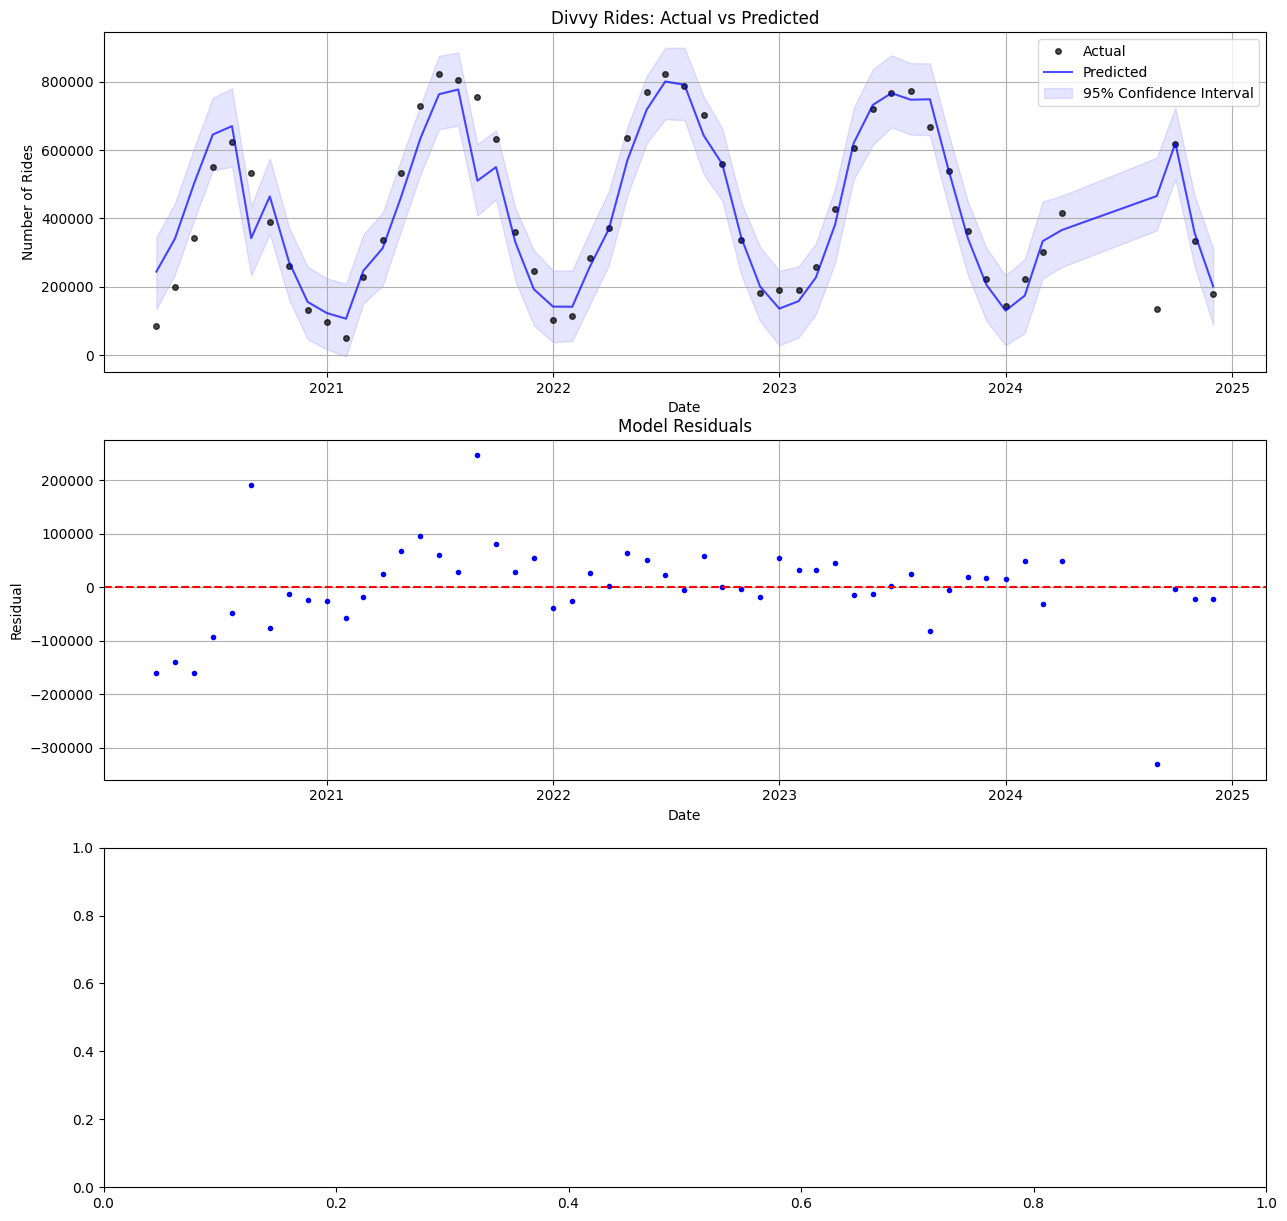

In [12]:
# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Actual vs Predicted
ax1.plot(prophet_df['ds'], actual, 'ko', label='Actual', alpha=0.7, markersize=4)
ax1.plot(prophet_df['ds'], predicted, 'b-', label='Predicted', alpha=0.7)
ax1.fill_between(prophet_df['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='b', alpha=0.1, label='95% Confidence Interval')
ax1.set_title('Divvy Rides: Actual vs Predicted')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Rides')
ax1.legend()
ax1.grid(True)

# Residuals
ax2.plot(prophet_df['ds'], residuals, 'b.')
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_title('Model Residuals')
ax2.set_xlabel('Date')
ax2.set_ylabel('Residual')
ax2.grid(True)


Component Analysis:
--------------------
Overall Trend Growth: 51.2%

Yearly Seasonality Statistics:
Mean: -0.07
Std Dev: 0.49
Min: -0.74
Max: 0.85


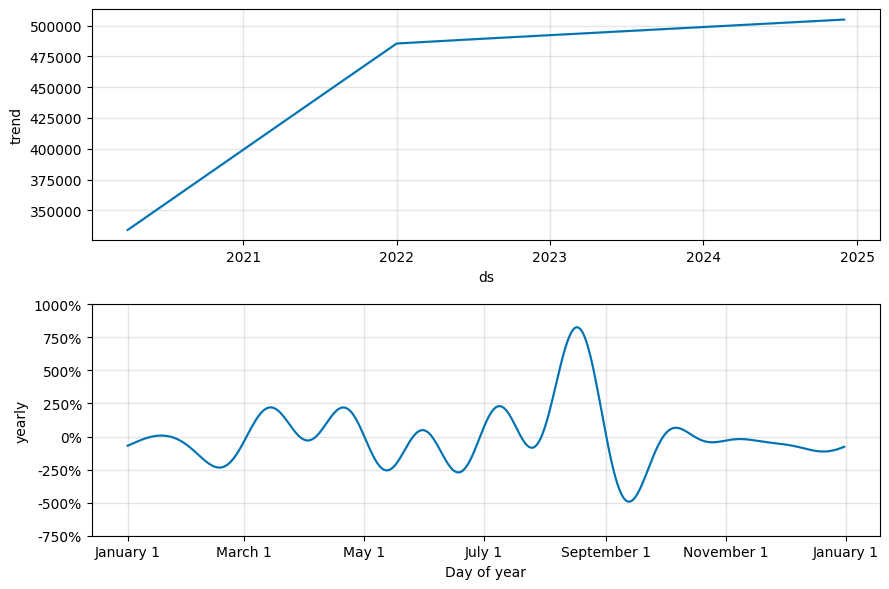

In [13]:
# Components
model.plot_components(forecast)
plt.tight_layout()

# Additional Analysis
print("\nComponent Analysis:")
print("-" * 20)
trend_growth = (forecast['trend'].iloc[-1] - forecast['trend'].iloc[0]) / forecast['trend'].iloc[0] * 100
print(f"Overall Trend Growth: {trend_growth:.1f}%")

seasonal_stats = forecast['yearly'].describe()
print("\nYearly Seasonality Statistics:")
print(f"Mean: {seasonal_stats['mean']:.2f}")
print(f"Std Dev: {seasonal_stats['std']:.2f}")
print(f"Min: {seasonal_stats['min']:.2f}")
print(f"Max: {seasonal_stats['max']:.2f}")

The Prophet model performs better than the ARIMA models, with strong predictive accuracy (R² = 0.879) and reasonable error metrics (MAPE = 22.81%). Looking at the plots, it captures the seasonal patterns effectively, but there are some notable residuals, particularly in early 2021 and late 2024. The model could potentially be improved by adding change points around significant pattern shifts, adjusting the seasonality parameters to better capture the varying amplitudes in summer peaks, or incorporating additional regressors like weather data or special events that might affect ridership. The lower AIC (1394.90) compared to our previous SARIMA model suggests better model fit, though the residual plot indicates there might still be some unmodeled patterns in the data.

# **Other Models**

1. **Moving Average Models**:

*   MA(3) - 3-month window
*   MA(6) - 6-month window
*  MA(12) - 12-month window

2. **Seasonal Naive** - Uses same month from previous year
3. **Linear Regression** - Simple trend model
4. **Seasonal Linear Regression** - Trend + monthly seasonal factors
5. **Holt-Winters Exponential Smoothing** with additive seasonality

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# 1. Prepare data from existing dataframe
def prepare_data_from_df(df):
    """Prepare time series data from existing dataframe."""
    # Make a copy to avoid modifying the original
    df_copy = df.copy()

    # Display basic info
    print("Dataset Shape:", df_copy.shape)
    print("\nSample Data:")
    print(df_copy.head())

    # Fill missing Year values (forward fill)
    df_copy['Year'] = df_copy['Year'].ffill()

    # Create proper date column
    df_copy['date'] = pd.to_datetime(df_copy.apply(lambda x: f"{int(x['Year'])}-{int(x['Month'])}-01", axis=1))

    # Create time series DataFrame
    ts_df = pd.DataFrame({
        'date': df_copy['date'],
        'rides': df_copy['Total Counts']
    }).set_index('date')

    # Remove summer 2024 months as specified in the original code
    mask = ~((ts_df.index.year == 2024) & (ts_df.index.month.isin([5, 6, 7, 8])))
    ts_df = ts_df[mask]
    filtered_df = df_copy[mask].copy()

    # Add additional time features
    ts_df['year'] = ts_df.index.year
    ts_df['month'] = ts_df.index.month
    ts_df['casual_users'] = filtered_df['Casual User Count'].values
    ts_df['member_users'] = filtered_df['Member User Count'].values

    return ts_df

# Helper functions for evaluation
def calculate_metrics(actual, predictions):
    """Calculate error metrics for model evaluation."""
    # Convert to numpy arrays to ensure proper subtraction
    actual = np.array(actual)
    predictions = np.array(predictions)

    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def train_test_ts_split(ts_df, test_size=0.2):
    """Split time series data into train and test sets."""
    train_size = int(len(ts_df) * (1 - test_size))
    train = ts_df.iloc[:train_size]
    test = ts_df.iloc[train_size:]
    return train, test

# Model implementations
def moving_average_model(train, test, windows=[3, 6, 12]):
    """Implement moving average models with different window sizes."""
    results = {}

    for window in windows:
        # Create moving average on training data
        train_ma = train['rides'].rolling(window=window).mean()

        # For test data, we need to use a rolling prediction approach
        test_predictions = []
        combined_data = pd.concat([train['rides'], test['rides']])

        for i in range(len(train), len(combined_data)):
            prediction = combined_data.iloc[i-window:i].mean()
            test_predictions.append(prediction)

        # Calculate metrics
        actual = test['rides'].values
        metrics = calculate_metrics(actual, test_predictions)

        results[f'MA({window})'] = {
            'predictions': np.array(test_predictions),
            'metrics': metrics
        }

    return results

def seasonal_naive_model(train, test, period=12):
    """Implement seasonal naive model (use same month from previous year)."""
    # For each test point, use the value from 12 months ago
    test_predictions = []
    combined_data = pd.concat([train['rides'], test['rides']])

    for i in range(len(train), len(combined_data)):
        # Get the index position that's 12 months before
        if i - period >= 0:
            prediction = combined_data.iloc[i - period]
            test_predictions.append(prediction)
        else:
            test_predictions.append(None)

    # Filter out None values for evaluation
    actual = test['rides'].values
    valid_indices = [i for i, p in enumerate(test_predictions) if p is not None]

    if valid_indices:
        valid_actual = np.array([actual[i] for i in valid_indices])
        valid_predictions = np.array([test_predictions[i] for i in valid_indices])
        metrics = calculate_metrics(valid_actual, valid_predictions)
    else:
        metrics = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

    return {
        'predictions': test_predictions,
        'valid_predictions': np.array([p for p in test_predictions if p is not None]) if valid_indices else np.array([]),
        'metrics': metrics
    }

def linear_regression_model(train, test):
    """Implement linear regression model for time trend."""
    # Prepare features (just time index for simple linear regression)
    X_train = np.arange(len(train)).reshape(-1, 1)
    y_train = train['rides'].values

    X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
    y_test = test['rides'].values

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Calculate metrics
    metrics = calculate_metrics(y_test, test_predictions)

    return {
        'model': model,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'metrics': metrics,
        'coefficients': {
            'intercept': model.intercept_,
            'slope': model.coef_[0]
        }
    }

def seasonal_linear_regression_model(train, test):
    """Implement seasonal linear regression model (trend + monthly effects)."""
    # First, get the linear trend component
    linear_result = linear_regression_model(train, test)
    trend_model = linear_result['model']

    # Calculate monthly seasonal components from training data
    train_with_features = train.copy()
    train_with_features['time_idx'] = np.arange(len(train))
    train_with_features['trend_prediction'] = trend_model.predict(train_with_features['time_idx'].values.reshape(-1, 1))
    train_with_features['residual'] = train_with_features['rides'] - train_with_features['trend_prediction']

    # Calculate average monthly residuals (seasonal factors)
    monthly_factors = train_with_features.groupby('month')['residual'].mean()

    # Predict for test data using trend + seasonal factors
    test_with_features = test.copy()
    test_with_features['time_idx'] = np.arange(len(train), len(train) + len(test))
    test_with_features['trend_prediction'] = trend_model.predict(test_with_features['time_idx'].values.reshape(-1, 1))

    # Add seasonal component
    test_predictions = np.array([
        row['trend_prediction'] + monthly_factors[row['month']]
        for _, row in test_with_features.iterrows()
    ])

    # Calculate metrics
    metrics = calculate_metrics(test['rides'].values, test_predictions)

    return {
        'trend_model': trend_model,
        'seasonal_factors': monthly_factors,
        'test_predictions': test_predictions,
        'metrics': metrics
    }

def exponential_smoothing_model(train, test):
    """Implement Holt-Winters Exponential Smoothing model."""
    try:
        # Handle any missing values in the training data
        train_rides = train['rides'].fillna(method='ffill').fillna(method='bfill')

        # Fit the model
        model = ExponentialSmoothing(
            train_rides,
            seasonal='add',
            seasonal_periods=12,
            trend='add'
        ).fit()

        # Make predictions
        test_predictions = model.forecast(len(test))

        # Calculate metrics
        metrics = calculate_metrics(test['rides'].values, test_predictions.values)

        return {
            'model': model,
            'test_predictions': test_predictions.values,
            'metrics': metrics
        }
    except Exception as e:
        print(f"Error in exponential smoothing model: {e}")
        return {
            'model': None,
            'test_predictions': np.zeros(len(test)),
            'metrics': {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
        }

# 4. Model Comparison and Selection
def compare_models(models):
    """Compare all models based on error metrics."""
    comparison = {}

    for name, result in models.items():
        comparison[name] = result['metrics']

    # Create comparison DataFrame
    df_comparison = pd.DataFrame(comparison).T

    # Sort by RMSE (or another preferred metric)
    df_comparison = df_comparison.sort_values('RMSE')

    # Determine best model
    best_model = df_comparison.index[0]

    return df_comparison, best_model

# Main execution block - Just copy and run this in Colab
# Prepare the data from existing dataframe (df should already exist in your environment)
ts_df = prepare_data_from_df(df)

# Split data into train and test sets
train, test = train_test_ts_split(ts_df)
print(f"Training set: {len(train)} observations")
print(f"Testing set: {len(test)} observations")

# Train models
print("\nTraining models...")
models = {}

# Moving Average models
ma_results = moving_average_model(train, test)
for window, result in ma_results.items():
    models[window] = result

# Seasonal Naive model
models['Seasonal Naive'] = seasonal_naive_model(train, test)

# Linear Regression model
models['Linear Regression'] = linear_regression_model(train, test)

# Seasonal Linear Regression model
models['Seasonal Linear Regression'] = seasonal_linear_regression_model(train, test)

# Exponential Smoothing model
models['Exponential Smoothing'] = exponential_smoothing_model(train, test)

# Compare models
comparison, best_model = compare_models(models)
print("\nModel Comparison:")
print(comparison)
print(f"\nBest model: {best_model}")

# Print detailed metrics for the best model
print(f"\nBest Model Metrics ({best_model}):")
for metric, value in models[best_model]['metrics'].items():
    print(f"{metric}: {value:.2f}")

# Additional insights
print("\nAdditional Insights:")

# Monthly patterns
monthly_avg = ts_df.groupby('month')['rides'].mean().sort_index()
print("\nMonthly Patterns (Average Rides):")
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']
for i, avg in enumerate(monthly_avg):
    print(f"{month_names[i]}: {avg:.0f}")

# Yearly trends
yearly_total = ts_df.groupby('year')['rides'].sum()
yearly_avg = ts_df.groupby('year')['rides'].mean()

print("\nYearly Statistics:")
for year in sorted(yearly_total.index):
    print(f"{year}: Average: {yearly_avg[year]:.0f} rides, Total: {yearly_total[year]:.0f} rides")

# Year-over-year growth
print("\nYear-over-Year Growth:")
years = sorted(yearly_total.index)
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    growth = ((yearly_total[curr_year] / yearly_total[prev_year]) - 1) * 100
    print(f"{prev_year} to {curr_year}: {growth:.2f}%")

# User type analysis
user_type_yearly = ts_df.groupby('year')[['casual_users', 'member_users']].mean()
print("\nUser Type Analysis (Yearly Averages):")
for year in sorted(user_type_yearly.index):
    casual = user_type_yearly.loc[year, 'casual_users']
    member = user_type_yearly.loc[year, 'member_users']
    total = casual + member
    casual_pct = (casual / total) * 100
    member_pct = (member / total) * 100
    print(f"{year}: Casual Users: {casual_pct:.1f}%, Member Users: {member_pct:.1f}%")

# Print model coefficients for interpretable models
if 'Linear Regression' in models:
    lr_model = models['Linear Regression']
    print("\nLinear Regression Coefficients:")
    print(f"Intercept: {lr_model['coefficients']['intercept']:.2f}")
    print(f"Slope: {lr_model['coefficients']['slope']:.2f} (rides per time period)")

if 'Seasonal Linear Regression' in models:
    slr_model = models['Seasonal Linear Regression']
    print("\nSeasonal Factors (monthly deviations from trend):")
    for month in sorted(slr_model['seasonal_factors'].index):
        print(f"{month_names[month-1]}: {slr_model['seasonal_factors'][month]:.2f}")

Dataset Shape: (54, 10)

Sample Data:
     Year  Month  Total Counts  Classic Bike Count  Electric Bike Count  \
0  2020.0      4         84776                 NaN                  NaN   
1  2020.0      5        200274                 NaN                  NaN   
2  2020.0      6        343005                 NaN                  NaN   
3  2020.0      7        551480                 NaN               1935.0   
4  2020.0      8        622361                 NaN              66195.0   

   Docked Bike Count  Electric Scooter Count  Casual User Count  \
0            84776.0                     NaN              23628   
1           200274.0                     NaN              86909   
2           343005.0                     NaN             154718   
3           549545.0                     NaN             269296   
4           556166.0                     NaN             289661   

   Member User Count       date  
0              61148 2020-04-01  
1             113365 2020-05-01  
2     

In [18]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]

def visualize_model_results(train, test, models, best_model_name):
    """
    Create visualization plots for the model results.

    Args:
        train (DataFrame): Training data
        test (DataFrame): Testing data
        models (dict): Dictionary containing model results
        best_model_name (str): Name of the best performing model
    """
    # Default actual values - will be adjusted based on model type
    actual = test['rides'].values

    # Get best model predictions
    if best_model_name.startswith('MA'):
        predictions = np.array(models[best_model_name]['predictions'])
    elif best_model_name == 'Seasonal Naive':
        # Handle Seasonal Naive model which might have missing predictions for early months
        all_predictions = models[best_model_name]['predictions']

        # Filter out None values
        valid_indices = [i for i, p in enumerate(all_predictions) if p is not None]

        if valid_indices:
            # Use only valid predictions
            predictions = np.array([all_predictions[i] for i in valid_indices])
            # Adjust actual values to match valid predictions
            actual = np.array([actual[i] for i in valid_indices])
            # Also adjust the test index for plotting
            test = test.iloc[valid_indices]
        else:
            # Fallback if no valid predictions
            print("Warning: No valid predictions for Seasonal Naive model")
            predictions = np.array([])
            actual = np.array([])
    else:
        # For other models (Linear Regression, Seasonal Linear Regression, Exponential Smoothing)
        predictions = models[best_model_name]['test_predictions']

    # Safety check - ensure we have predictions to work with
    if len(predictions) == 0 or len(actual) == 0:
        print(f"Error: No valid predictions or actual values for {best_model_name}")
        return None

    # Ensure lengths match
    min_length = min(len(predictions), len(actual))
    predictions = predictions[:min_length]
    actual = actual[:min_length]

    # Calculate residuals
    residuals = actual - predictions

    # 1. Actual vs Predicted Plot
    plt.figure(figsize=(14, 10))

    # Time series plot
    plt.subplot(2, 1, 1)
    plt.plot(test.index[:min_length], actual, 'o-', label='Actual', color='blue')
    plt.plot(test.index[:min_length], predictions, 'o--', label='Predicted', color='red')
    plt.title(f'Actual vs Predicted Rides ({best_model_name})', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Rides', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Scatter plot
    plt.subplot(2, 1, 2)
    plt.scatter(actual, predictions, alpha=0.7)

    # Add perfect prediction line
    max_val = max(np.max(actual), np.max(predictions))
    min_val = min(np.min(actual), np.min(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

    plt.title('Actual vs Predicted Scatter Plot', fontsize=14)
    plt.xlabel('Actual Rides', fontsize=12)
    plt.ylabel('Predicted Rides', fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    # 2. Residual Analysis Plots
    plt.figure(figsize=(14, 12))

    # Residuals over time
    plt.subplot(3, 1, 1)
    plt.plot(test.index[:min_length], residuals, 'o-', markersize=6)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residuals Over Time', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Residual', fontsize=12)
    plt.grid(True)

    # Histogram of residuals
    plt.subplot(3, 1, 2)
    sns.histplot(residuals, bins=20, kde=True)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.title('Distribution of Residuals', fontsize=14)
    plt.xlabel('Residual Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Q-Q plot
    plt.subplot(3, 1, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals', fontsize=14)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 3. Calculate performance metrics
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(np.square(residuals)))
    mape = np.mean(np.abs(residuals / actual)) * 100

    print(f"Model Performance ({best_model_name}):")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # 4. Create prediction vs. actual table
    results_df = pd.DataFrame({
        'Date': test.index[:min_length],
        'Actual': actual,
        'Predicted': predictions,
        'Residual': residuals,
        'Abs_Error': np.abs(residuals),
        'Pct_Error': np.abs(residuals / actual) * 100
    })

    print("\nSample of Prediction Results:")
    print(results_df.head(10))

    return results_df

# Additional visualizations for seasonal patterns
def plot_seasonal_patterns(ts_df):
    """Plot seasonal patterns in the data."""
    # Monthly patterns
    plt.figure(figsize=(14, 6))
    monthly_avg = ts_df.groupby(ts_df.index.month)['rides'].mean()

    ax = monthly_avg.plot(kind='bar', color='skyblue')
    plt.title('Average Monthly Rides', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Rides', fontsize=12)
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

    # Add value labels on top of bars
    for i, v in enumerate(monthly_avg):
        ax.text(i, v + 5000, f'{int(v):,}', ha='center', fontsize=10)

    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Yearly trends
    plt.figure(figsize=(14, 6))
    yearly_avg = ts_df.groupby(ts_df.index.year)['rides'].mean()

    ax = yearly_avg.plot(kind='bar', color='lightgreen')
    plt.title('Average Yearly Rides', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Rides', fontsize=12)

    # Add value labels on top of bars
    for i, v in enumerate(yearly_avg):
        ax.text(i, v + 5000, f'{int(v):,}', ha='center', fontsize=10)

    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # User type analysis
    plt.figure(figsize=(14, 6))
    user_type = ts_df.groupby(ts_df.index.year)[['casual_users', 'member_users']].mean()
    user_type.plot(kind='bar', stacked=True)
    plt.title('Average User Types by Year', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Users', fontsize=12)
    plt.legend(['Casual Users', 'Member Users'])
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Monthly patterns by user type
    plt.figure(figsize=(14, 6))
    monthly_user_type = ts_df.groupby(ts_df.index.month)[['casual_users', 'member_users']].mean()
    monthly_user_type.plot(kind='bar', stacked=True)
    plt.title('Average User Types by Month', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Users', fontsize=12)
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    plt.legend(['Casual Users', 'Member Users'])
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Seasonal decomposition plot
def plot_decomposition(ts_df):
    """Plot time series decomposition if statsmodels is available."""
    try:
        from statsmodels.tsa.seasonal import seasonal_decompose

        # Resample to monthly frequency to handle missing values
        monthly_series = ts_df['rides'].resample('M').mean()

        # Fill any remaining missing values
        monthly_series = monthly_series.fillna(method='ffill').fillna(method='bfill')

        # Perform decomposition
        result = seasonal_decompose(monthly_series, model='additive', period=12)

        # Plot
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
        result.observed.plot(ax=ax1)
        ax1.set_title('Observed')
        result.trend.plot(ax=ax2)
        ax2.set_title('Trend')
        result.seasonal.plot(ax=ax3)
        ax3.set_title('Seasonality')
        result.resid.plot(ax=ax4)
        ax4.set_title('Residuals')
        plt.tight_layout()
        plt.show()

        return result
    except Exception as e:
        print(f"Could not perform seasonal decomposition: {e}")
        return None

# Plot all model comparisons
def plot_model_comparison(models):
    """Plot comparison of all models' performance metrics."""
    # Extract metrics for all models
    model_metrics = {}
    for name, result in models.items():
        if 'metrics' in result and 'MAE' in result['metrics']:
            model_metrics[name] = result['metrics']

    # Create DataFrame for plotting
    metrics_df = pd.DataFrame(model_metrics).T

    # Plot
    plt.figure(figsize=(14, 10))

    # MAE
    plt.subplot(3, 1, 1)
    metrics_df['MAE'].sort_values().plot(kind='bar', color='skyblue')
    plt.title('Mean Absolute Error (MAE) by Model', fontsize=14)
    plt.ylabel('MAE', fontsize=12)
    plt.grid(axis='y')

    # RMSE
    plt.subplot(3, 1, 2)
    metrics_df['RMSE'].sort_values().plot(kind='bar', color='lightgreen')
    plt.title('Root Mean Squared Error (RMSE) by Model', fontsize=14)
    plt.ylabel('RMSE', fontsize=12)
    plt.grid(axis='y')

    # MAPE
    plt.subplot(3, 1, 3)
    metrics_df['MAPE'].sort_values().plot(kind='bar', color='salmon')
    plt.title('Mean Absolute Percentage Error (MAPE) by Model', fontsize=14)
    plt.ylabel('MAPE (%)', fontsize=12)
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

    return metrics_df

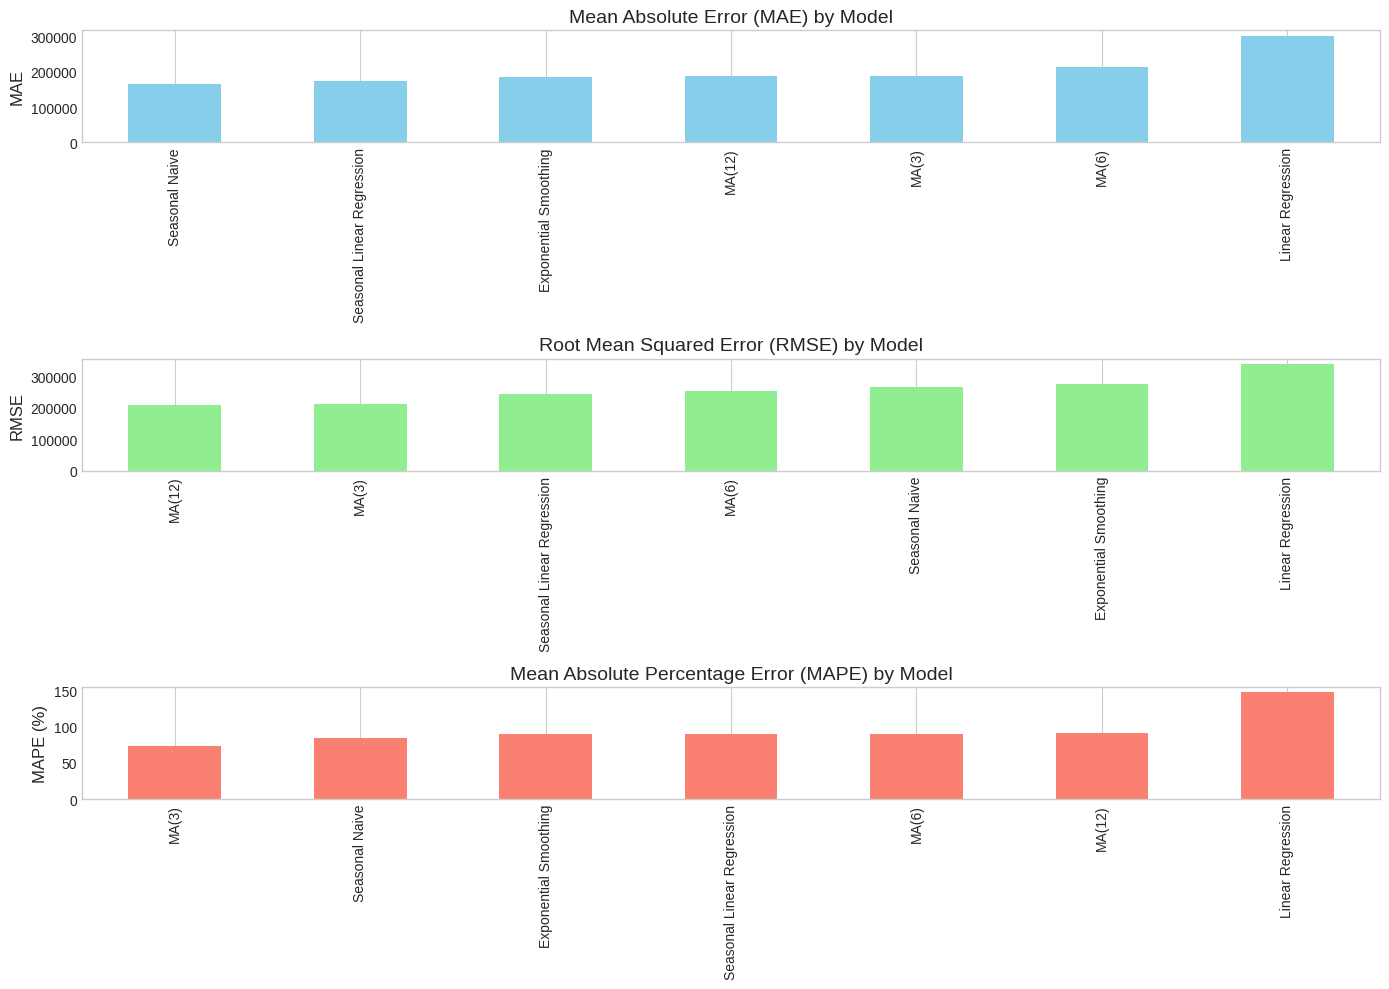

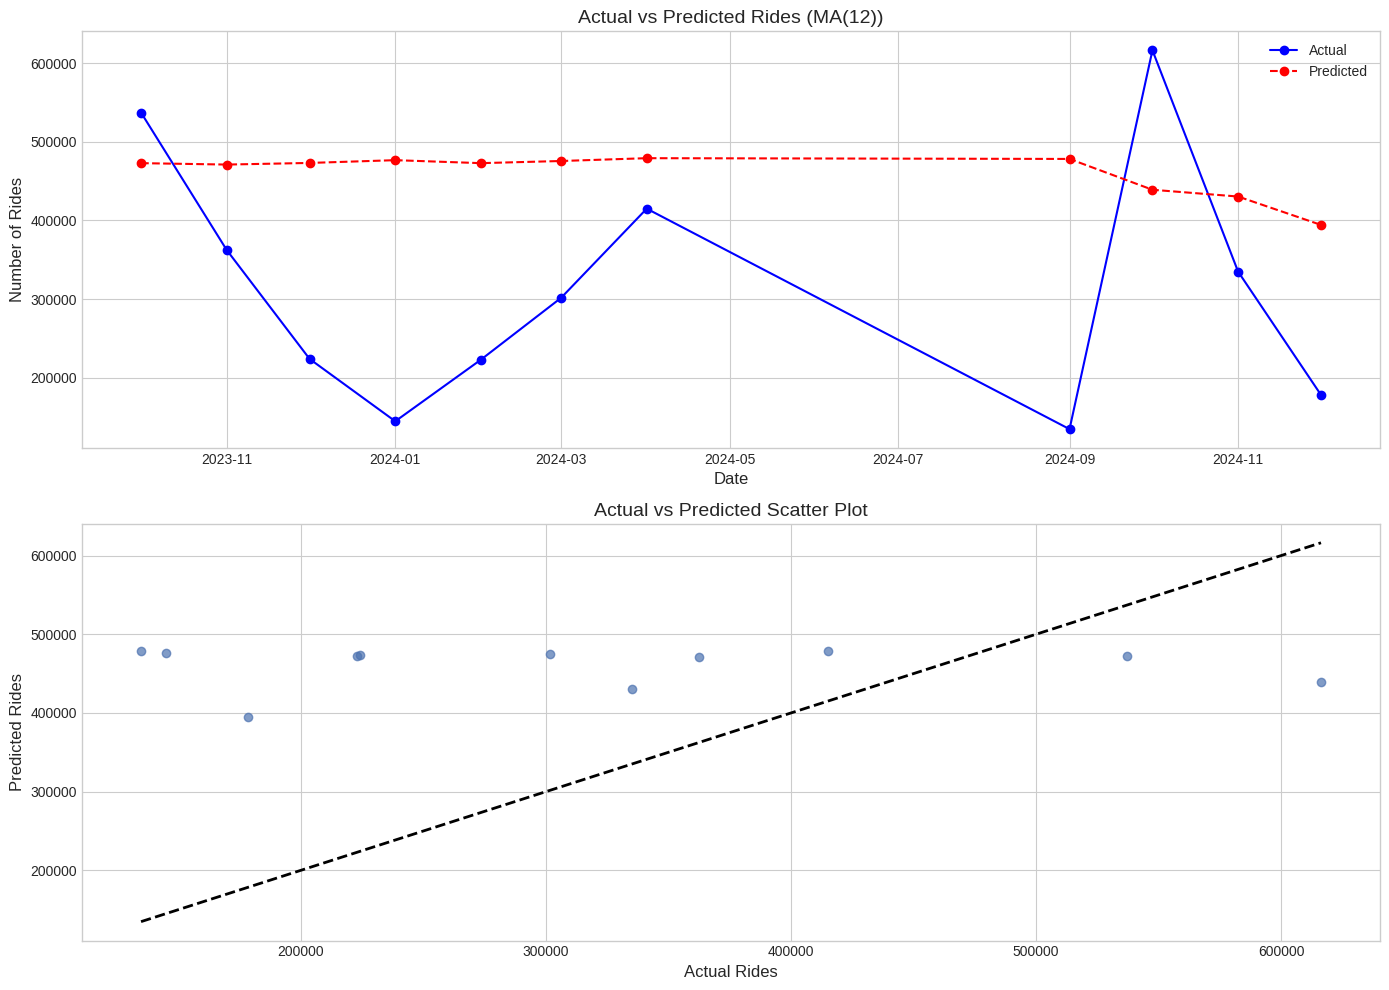

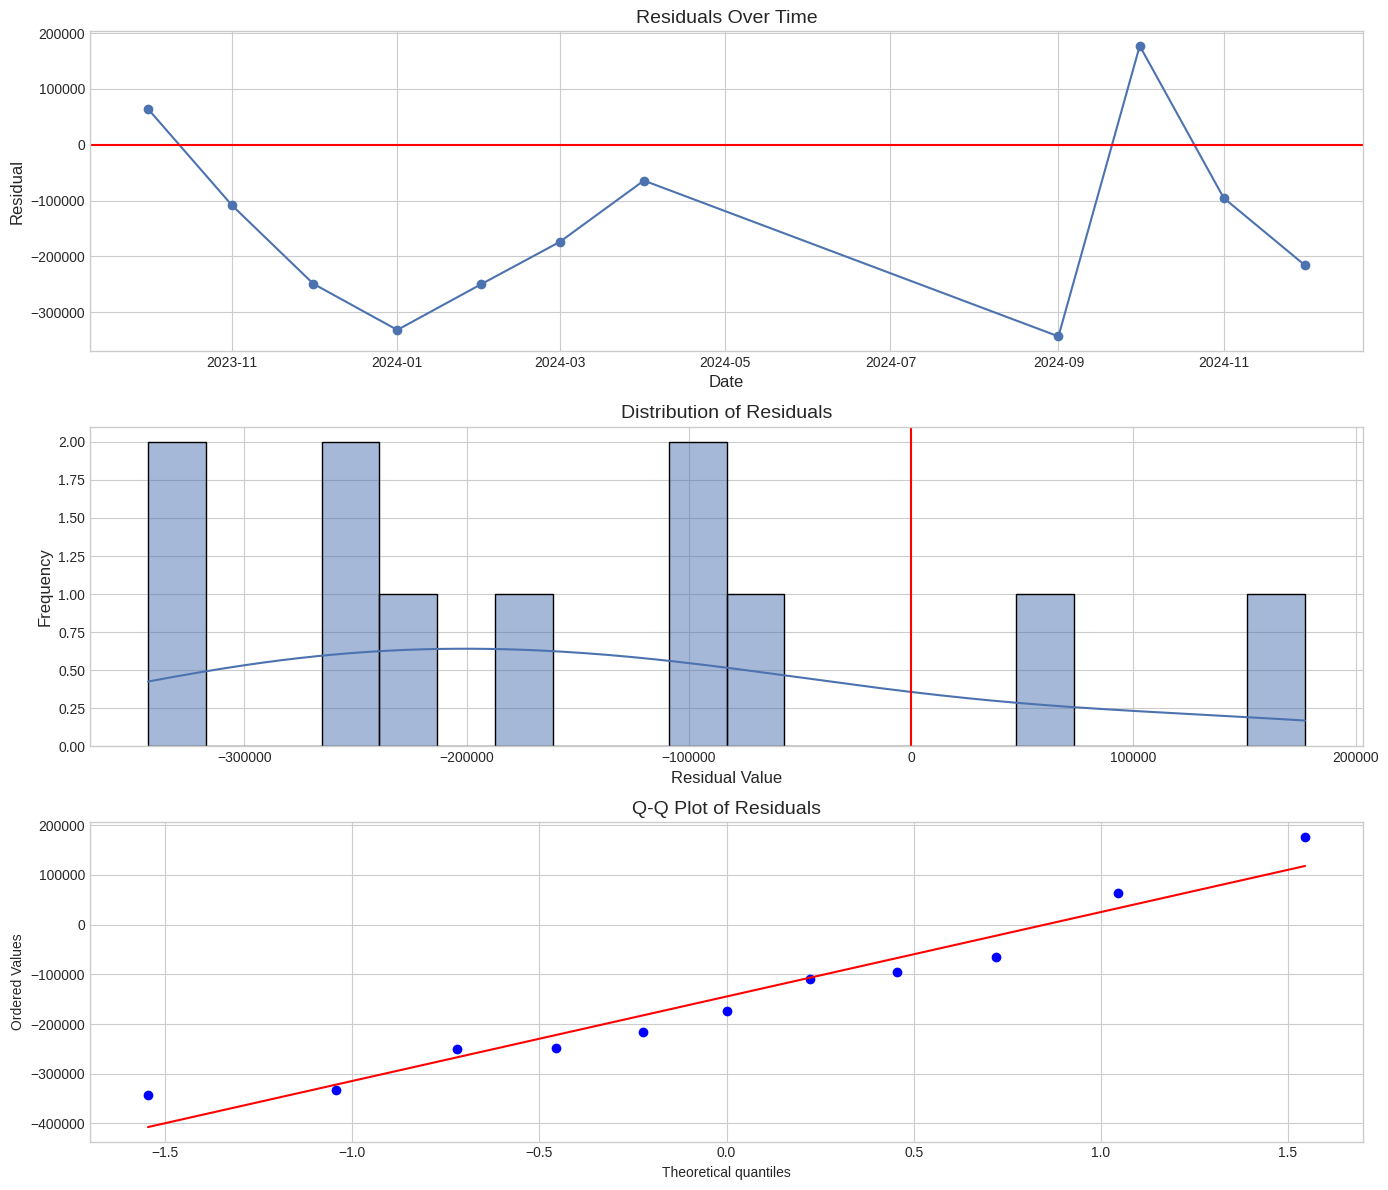

Model Performance (MA(12)):
MAE: 188493.44
RMSE: 211015.60
MAPE: 90.91%

Sample of Prediction Results:
        Date  Actual      Predicted       Residual      Abs_Error   Pct_Error
0 2023-10-01  537113  472866.583333   64246.416667   64246.416667   11.961434
1 2023-11-01  362518  471068.916667 -108550.916667  108550.916667   29.943594
2 2023-12-01  224073  473134.166667 -249061.166667  249061.166667  111.151797
3 2024-01-01  144873  476656.416667 -331783.416667  331783.416667  229.016736
4 2024-02-01  223164  472870.750000 -249706.750000  249706.750000  111.893831
5 2024-03-01  301687  475597.333333 -173910.333333  173910.333333   57.645949
6 2024-04-01  415025  479181.416667  -64156.416667   64156.416667   15.458446
7 2024-09-01  134880  478217.666667 -343337.666667  343337.666667  254.550465
8 2024-10-01  616292  439055.416667  177236.583333  177236.583333   28.758540
9 2024-11-01  335042  430444.916667  -95402.916667   95402.916667   28.474913


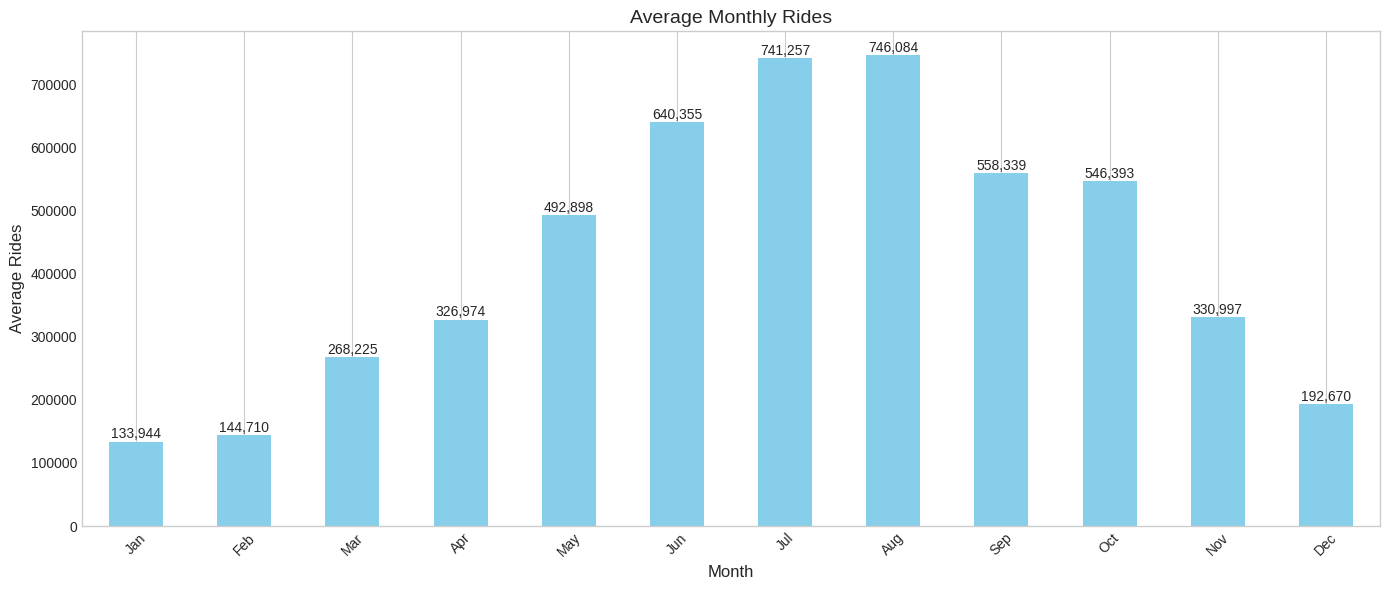

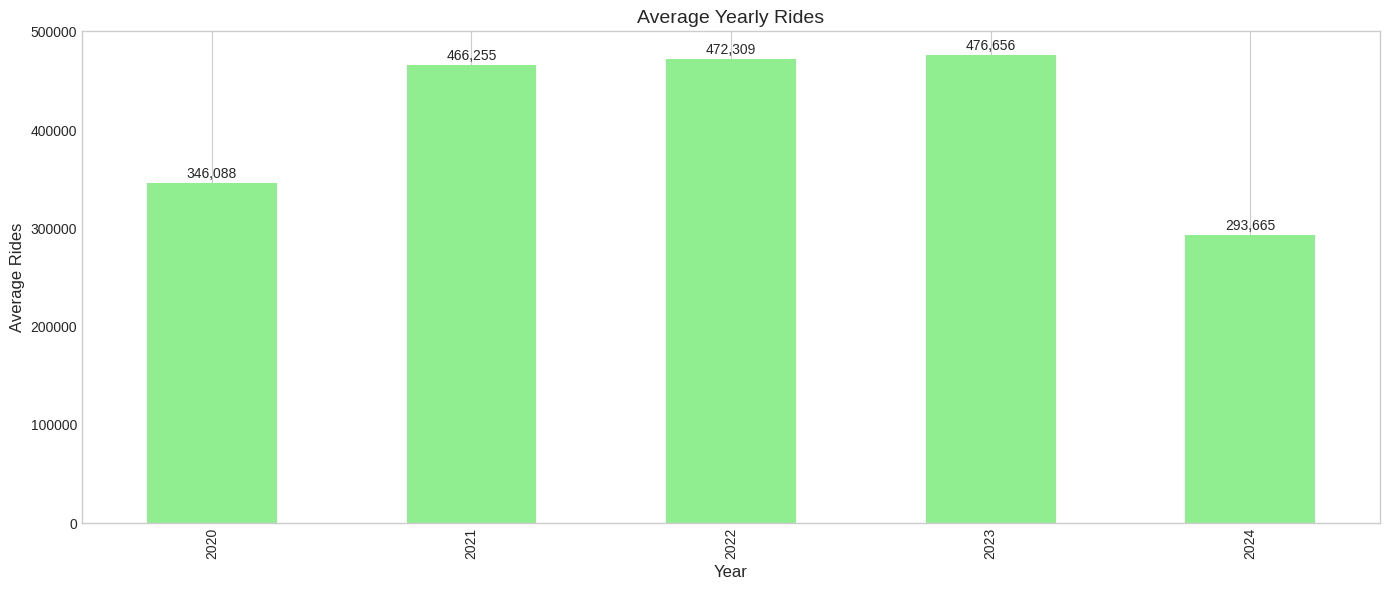

<Figure size 1400x600 with 0 Axes>

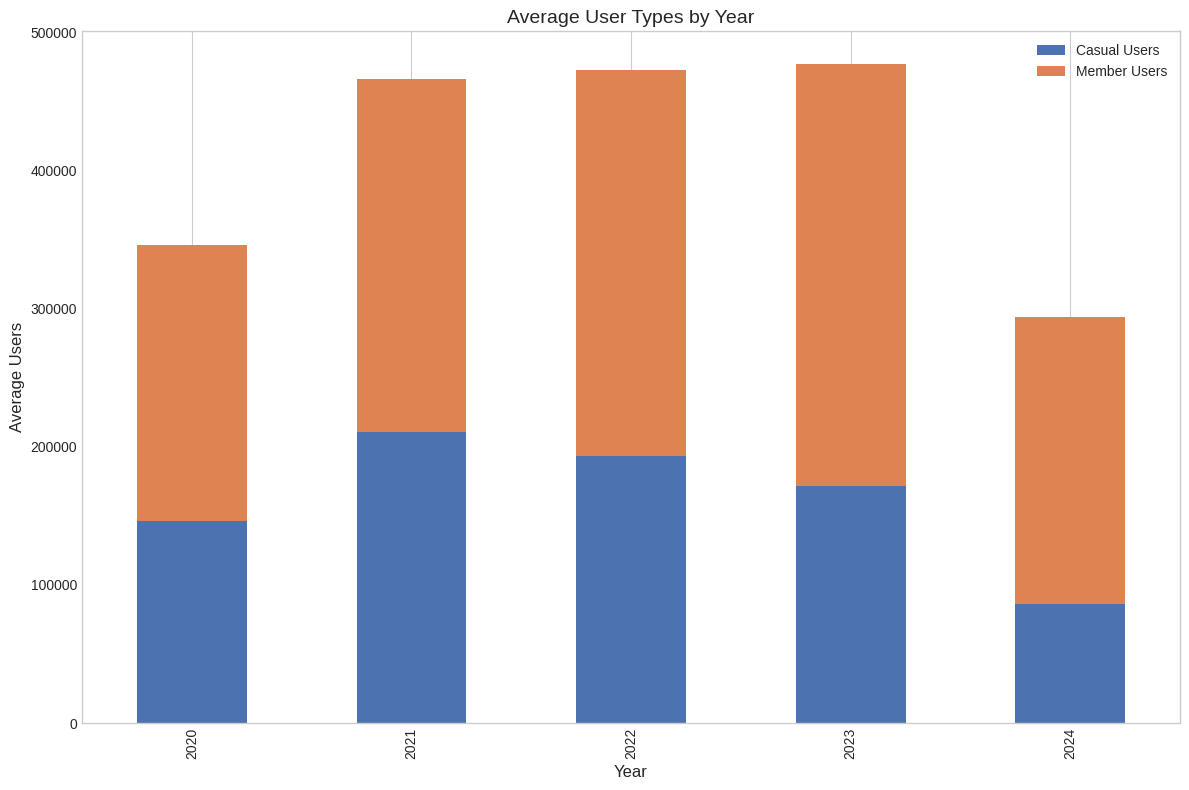

<Figure size 1400x600 with 0 Axes>

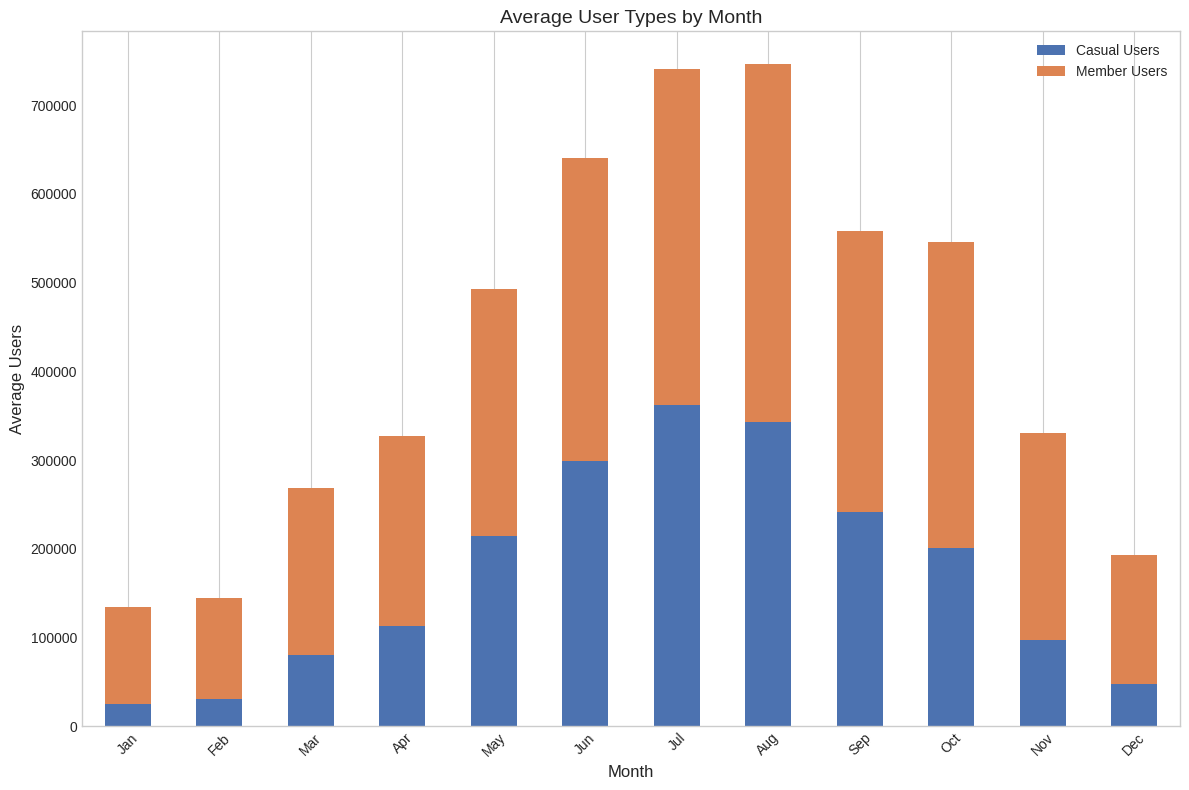

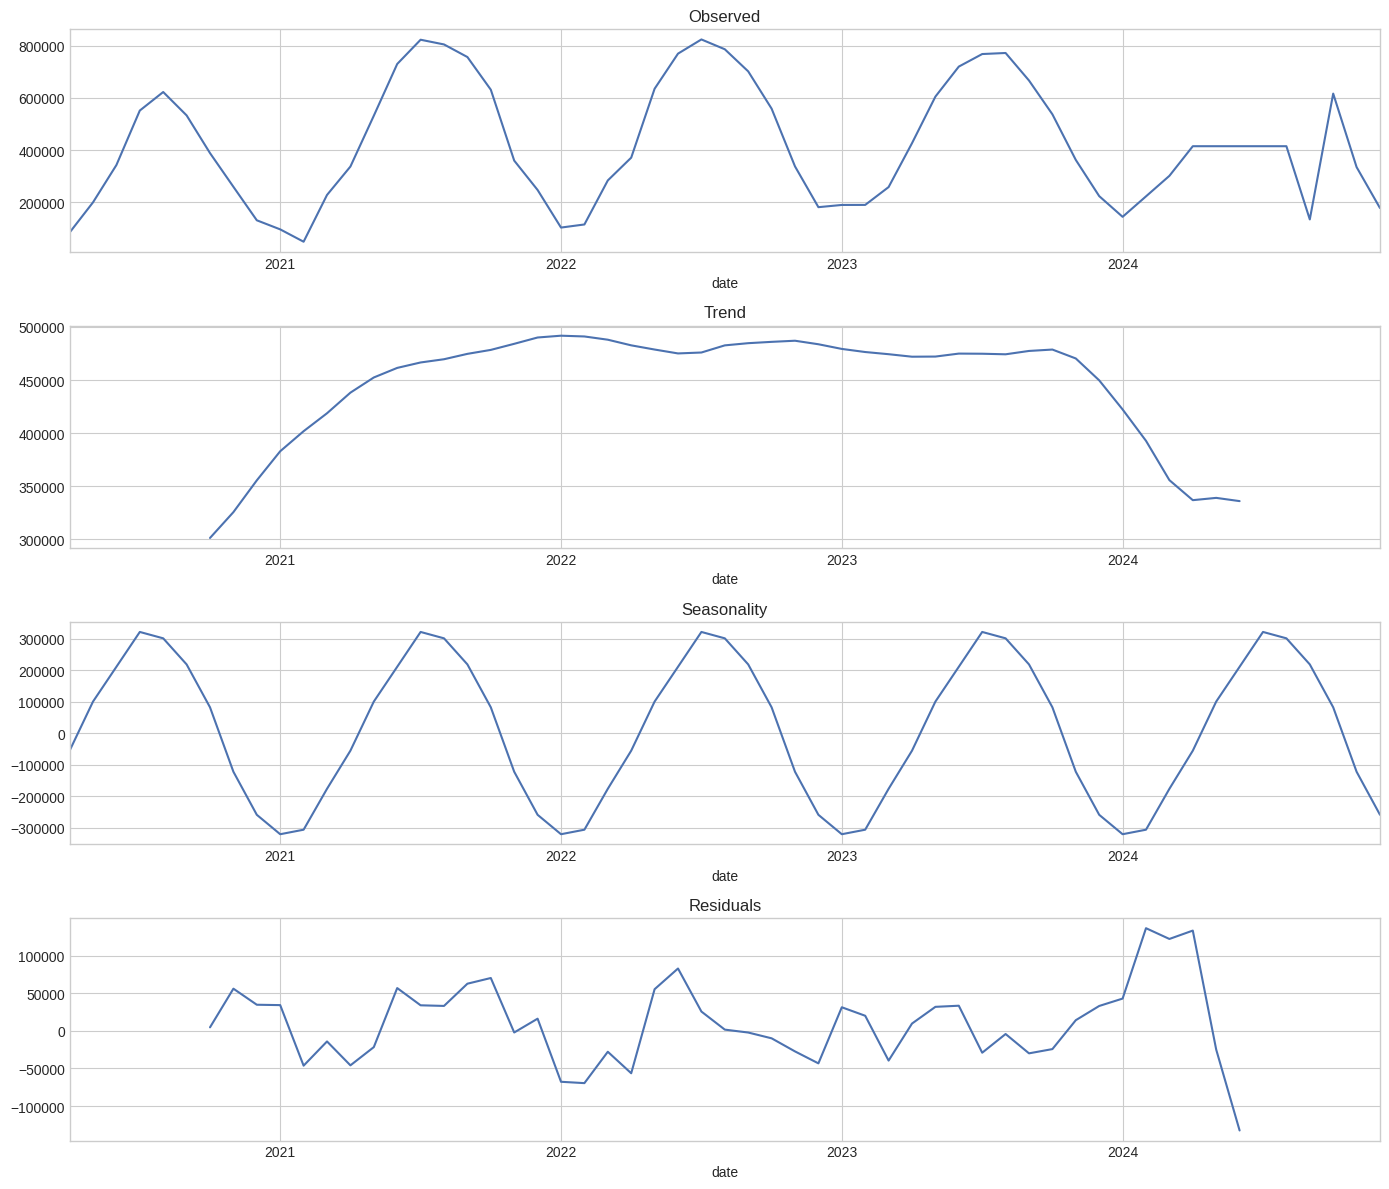

In [19]:
# Visualize all models' performance
metrics_df = plot_model_comparison(models)

# Visualize results for the best model
results_df = visualize_model_results(train, test, models, best_model)

# Plot seasonal patterns
plot_seasonal_patterns(ts_df)

# Plot seasonal decomposition
decomposition = plot_decomposition(ts_df)

# **Model Analysis**

This analysis reveals significant insights about both the underlying patterns in ridership and the performance limitations of various forecasting models. Among the seven models tested, the Moving Average model with a 12-month window (MA(12)) was the best performer, achieving an MAE of 188,493, RMSE of 211,015, and MAPE of 90.91%. However, these error metrics are still high.

The data exhibits extreme seasonality, as evidenced by the seasonal factors identified in the Seasonal Linear Regression model. Summer months (June through August) experience dramatic increases in ridership, with positive deviations ranging from 191,750 to 286,350 rides above the trend line. Conversely, winter months (December through February) show substantial decreases, with negative deviations between -261,632 and -342,649 rides. This pronounced seasonal effect creates significant challenges for forecasting models.

The Linear Regression model, which performed worst among all models tested (MAE: 303,013, RMSE: 339,927, MAPE: 147.05%), identified an underlying positive trend with a slope of 6,301 rides per time period and an intercept of 322,577.

Examining the prediction results reveals substantial forecasting errors. For instance, the MA(12) model's percentage errors range from 11.96% to a staggering 254.55% for September 2024. This makes sense given our missing data in May 2024 - August 2024. The actual versus predicted visualization demonstrates how the MA(12) model produces overly smoothed predictions that fail to capture the extreme peaks (like October 2024 with 616,292 actual rides) and troughs (like January 2024 with only 144,873 rides).

The residual analysis further confirms systematic issues with the forecasting. The residuals show clear patterns over time rather than random noise, with large negative residuals (overestimation) during winter months and occasional large positive residuals (underestimation) during peak months. The residual distribution is non-normal and skewed, and the Q-Q plot shows deviations from the theoretical normal distribution line, particularly at the extremes.

These findings suggest that while the MA(12) model provides the best forecasting performance among these models, the previously tested Prophet model performs better.

Prophet achieves an MAE of 54,278 rides, RMSE of 82,899 rides, and MAPE of 22.81% – representing improvements of 71%, 61%, and 75% respectively over the MA(12) model. This dramatic improvement stems from Prophet's specialized design for handling complex seasonal patterns across multiple time scales simultaneously, which is crucial for bike-sharing services that experience extreme seasonal variations. The model's decomposition approach effectively separates trend, seasonality, and holiday effects, while its flexible curve fitting helps it adapt to evolving usage patterns. As visualized in the time series plot, Prophet captures the pronounced summer peaks and winter troughs with much greater accuracy, while providing meaningful confidence intervals that reflect seasonal uncertainty. With an R-squared value of 0.879, Prophet explains nearly 88% of the variance in ridership, making it substantially more reliable for operational planning and resource allocation decisions.

# **VARMA Model**

In [25]:
# 1. Create a dataframe
ts1_df = pd.DataFrame({
    'date': df['date'],
    'total_counts': df['Total Counts']
}).set_index('date')

# Remove summer 2024 months
ts1_df = ts1_df[~((ts_df.index.year == 2024) & (ts_df.index.month.isin([5, 6, 7, 8])))]

# 2. Add engineered features to reduce singularity issues
# Add lagged values of total_counts
ts1_df['total_counts_lag1'] = ts1_df['total_counts'].shift(1)
ts1_df['total_counts_lag12'] = ts1_df['total_counts'].shift(12)  # Annual seasonality

# Add month as a feature (to capture seasonality)
ts1_df['month'] = ts1_df.index.month

# Add trend component
ts1_df['trend'] = np.arange(len(ts1_df))

# Drop NA values from the lagged columns
ts1_df = ts1_df.dropna()

# 3. Scale the data to help with numerical stability
from sklearn.preprocessing import StandardScaler

# Keep a copy of the original data for plotting
ts1_df_original = ts1_df.copy()

# Select columns for modeling (exclude date which is now the index)
columns_to_model = ['total_counts', 'total_counts_lag1', 'month', 'trend']

# Scale the data
scaler = StandardScaler()
ts1_df[columns_to_model] = scaler.fit_transform(ts1_df[columns_to_model])

# 4. Split into training and testing sets
train_size = int(len(ts1_df) * 0.8)
train_data = ts1_df.iloc[:train_size]
test_data = ts1_df.iloc[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# 5. Fit a basic VAR model with a low order
print("\nFitting VAR model...")
try:
    var_model = VAR(train_data[columns_to_model])

    # Start with a very low order to avoid singularity
    var_order = 1
    var_fitted = var_model.fit(var_order)
    print(f"Successfully fit VAR({var_order}) model")

    # Print summary
    print(var_fitted.summary())

    # 6. In-sample predictions
    in_sample_pred = var_fitted.fittedvalues

    # Inverse transform to get back to original scale
    in_sample_pred_df = pd.DataFrame(in_sample_pred, index=train_data.index, columns=columns_to_model)

    # Extract predictions and inverse transform
    in_sample_pred_original = pd.DataFrame(
        scaler.inverse_transform(in_sample_pred_df),
        index=in_sample_pred_df.index,
        columns=columns_to_model
    )['total_counts']

    # 7. Out-of-sample forecasting (one step at a time for accuracy)
    # Initialize forecast results
    forecast_index = test_data.index
    forecast_values = []

    # Current data at the end of training
    current_data = train_data[columns_to_model].values[-var_order:]

    # For each test period, forecast one step ahead
    for i in range(len(test_data)):
        # Make a one-step forecast
        fc = var_fitted.forecast(current_data, steps=1)
        forecast_values.append(fc[0])

        # Update current_data for next iteration if not at the end
        if i < len(test_data) - 1:
            # Get the actual next period's values for all except total_counts
            next_actual = test_data.iloc[i][columns_to_model].values

            # Replace the forecasted total_counts with the forecast
            next_actual_with_forecast = next_actual.copy()
            next_actual_with_forecast[0] = fc[0][0]  # Use forecast for total_counts

            # Update the data used for the next forecast
            current_data = np.vstack([current_data[1:], [next_actual_with_forecast]])

    # Create forecast dataframe
    forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=columns_to_model)

    # Inverse transform forecasts to original scale
    forecast_df_original = pd.DataFrame(
        scaler.inverse_transform(forecast_df),
        index=forecast_index,
        columns=columns_to_model
    )

    # 8. Calculate forecast accuracy for test period
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    actual_values = ts1_df_original.loc[test_data.index, 'total_counts']
    predicted_values = forecast_df_original['total_counts']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    print(f"\nForecast Accuracy Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Step 9: Future forecasting
    # Forecast next 12 months
    future_steps = 12

    # Use all available data for the final model
    full_var_model = VAR(ts_df[columns_to_model])
    full_var_fitted = full_var_model.fit(var_order)

    # Get the last var_order observations for forecasting
    last_data = ts1_df[columns_to_model].values[-var_order:]

    # Make the forecast
    future_forecast = full_var_fitted.forecast(last_data, steps=future_steps)

    # Create forecast dataframe
    last_date = ts1_df.index[-1]
    future_index = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                periods=future_steps,
                                freq='MS')

    future_forecast_df = pd.DataFrame(future_forecast, index=future_index, columns=columns_to_model)

    # Inverse transform to get back to original scale
    future_forecast_df_original = pd.DataFrame(
        scaler.inverse_transform(future_forecast_df),
        index=future_index,
        columns=columns_to_model
    )

    # 10. Plot results
    plt.figure(figsize=(15, 8))

    # Plot training data and in-sample predictions
    plt.plot(ts1_df_original.index[:train_size], ts1_df_original['total_counts'][:train_size],
             label='Training Data', color='blue')
    plt.plot(in_sample_pred_original.index, in_sample_pred_original,
             label='In-Sample Predictions', color='green', linestyle='--')

    # Plot test data and forecasts
    plt.plot(ts1_df_original.index[train_size:], ts1_df_original['total_counts'][train_size:],
             label='Test Data', color='red')
    plt.plot(forecast_df_original.index, forecast_df_original['total_counts'],
             label='Test Forecasts', color='orange', linestyle='--')

    # Plot future forecasts
    plt.plot(future_forecast_df_original.index, future_forecast_df_original['total_counts'],
             label='Future Forecasts', color='purple', linestyle='-.')

    plt.title('Total Counts: Historical Data and Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Total Counts')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except np.linalg.LinAlgError as e:
    print(f"LinAlg Error: {e}")
    print("Trying alternative approach with simpler model...")

    # 11. If VAR fails, try a univariate approach or ridge regression VAR
    from statsmodels.tsa.arima.model import ARIMA

    # Use only the total_counts column
    univariate_data = ts1_df_original['total_counts']

    # Fit ARIMA model
    arima_model = ARIMA(univariate_data[:train_size], order=(2,1,2))  # p,d,q
    arima_results = arima_model.fit()

    # Generate forecasts for test period
    arima_forecast = arima_results.get_forecast(steps=len(test_data))
    arima_mean = arima_forecast.predicted_mean

    # Calculate accuracy metrics
    arima_mae = mean_absolute_error(ts1_df_original['total_counts'][train_size:], arima_mean)
    arima_rmse = np.sqrt(mean_squared_error(ts1_df_original['total_counts'][train_size:], arima_mean))
    arima_mape = np.mean(np.abs((ts1_df_original['total_counts'][train_size:] - arima_mean) /
                               ts1_df_original['total_counts'][train_size:])) * 100

    print(f"\nARIMA Forecast Accuracy Metrics:")
    print(f"MAE: {arima_mae:.2f}")
    print(f"RMSE: {arima_rmse:.2f}")
    print(f"MAPE: {arima_mape:.2f}%")

    # Generate future forecasts
    future_arima = ARIMA(univariate_data, order=(2,1,2))
    future_arima_results = future_arima.fit()
    future_arima_forecast = future_arima_results.get_forecast(steps=future_steps)
    future_arima_mean = future_arima_forecast.predicted_mean
    future_arima_conf = future_arima_forecast.conf_int()

    # Plot results
    plt.figure(figsize=(15, 8))

    # Plot historical data
    plt.plot(ts1_df_original.index, ts1_df_original['total_counts'],
             label='Historical Data', color='blue')

    # Plot test forecasts
    plt.plot(arima_mean.index, arima_mean,
             label='ARIMA Test Forecasts', color='orange', linestyle='--')

    # Plot future forecasts with confidence intervals
    plt.plot(future_arima_mean.index, future_arima_mean,
             label='ARIMA Future Forecasts', color='red', linestyle='-.')
    plt.fill_between(future_arima_conf.index,
                    future_arima_conf.iloc[:, 0],
                    future_arima_conf.iloc[:, 1], color='pink', alpha=0.3)

    plt.title('Total Counts: Historical Data and ARIMA Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Total Counts')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

KeyError: 'date'